### This is an elaboration of what we have trialed before adapting the final version of our model. All the codes following are extracted from different sketches notebook, hence they are not available for running.

In [ ]:
# Common imports
import numpy as np
import pandas as pd
import time
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
data_path = '/Users/yz6622/EDSML/term_3/Big_Data_Module/big-data-analytics/bda-assessment-edsml-yz6622/Dataset/'

In [3]:
#load the training data and reshape
train = np.load(data_path+'Ferguson_fire_train.npy')
print(f"Train data before reshaping: {np.shape(train)}")

train_1D = np.reshape(train, (np.shape(train)[0],np.shape(train)[1]*np.shape(train)[2]))
print(f"Train data after reshaping: {train_1D.shape}")

Train data before reshaping: (12500, 256, 256)
Train data after reshaping: (12500, 65536)


In [4]:
#load the test data and reshape
test = np.load(data_path+'Ferguson_fire_test.npy')
print(f"Test data before reshaping: {np.shape(test)}")

test_1D = np.reshape(test, (np.shape(test)[0],np.shape(test)[1]*np.shape(test)[2]))
print(f"Test data after reshaping: {test_1D.shape}")

Test data before reshaping: (5000, 256, 256)
Test data after reshaping: (5000, 65536)


In [23]:
print('Mean of the train set:', train.mean())
print('Standard deviation of the train set:', train.std())
print('Maximum value of the train set:', train.max())
print('Minimum value of the train set:', train.min())

Mean of the train set: 0.03752271484375
Standard deviation of the train set: 0.19003884001569726
Maximum value of the train set: 1
Minimum value of the train set: 0


In [24]:
print('Mean of the test set:', test.mean())
print('Standard deviation of the test set:', test.std())
print('Maximum value of the test set:', test.max())
print('Minimum value of the test set:', test.min())

Mean of the test set: 0.03520714416503906
Standard deviation of the test set: 0.18430301452982936
Maximum value of the test set: 1
Minimum value of the test set: 0


**Our data have been normalized as they are all between 0 and 1, hence there is no need for extra scaling.**

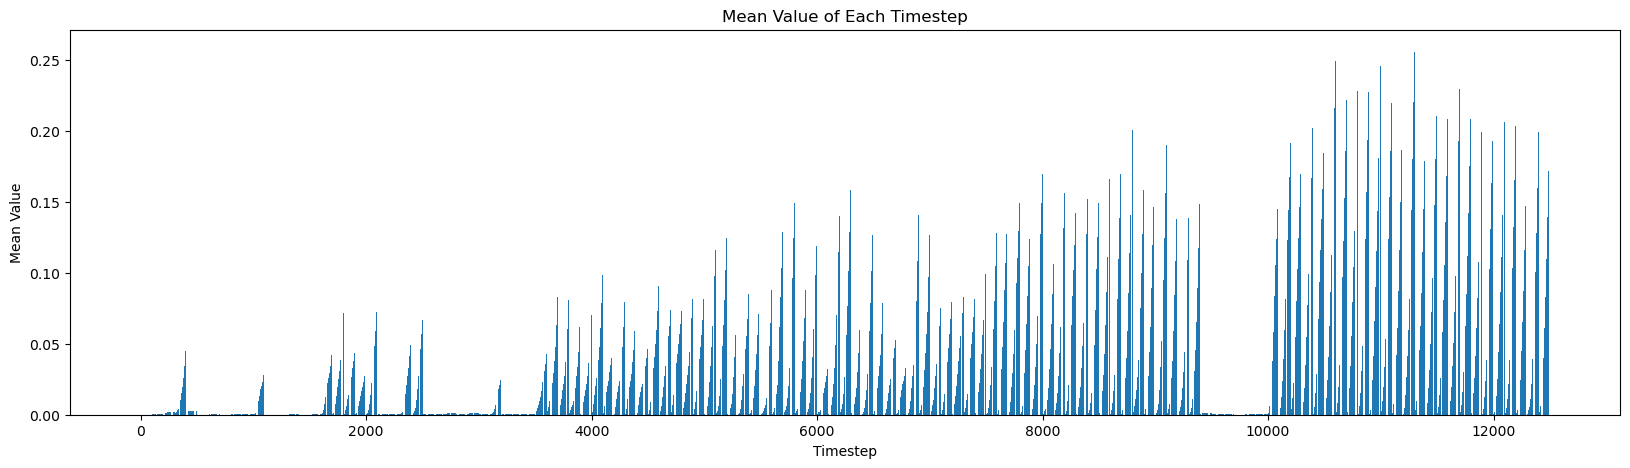

In [5]:
# Compute the average at each timestep
means = np.mean(train, axis=(1,2))

plt.figure(figsize=(20,5))

# Create a histogram
plt.bar(range(len(means)), means)

plt.title('Mean Value of Each Timestep')
plt.xlabel('Timestep')
plt.ylabel('Mean Value')

# Display image
plt.show()

**The histogram represents the respective mean values of 12500 timesteps. It can be seen from gaps between bars that the train data is not continuous in 12500 time steps. This illustrates the train data contains multiple different fires. However, we cannot ensure what timesteps represent one fire since the timesteps are not consistent for each fire. Hence, we split the training data into 125 individual sets with 100 timesteps in a set to avoid misclassification.**

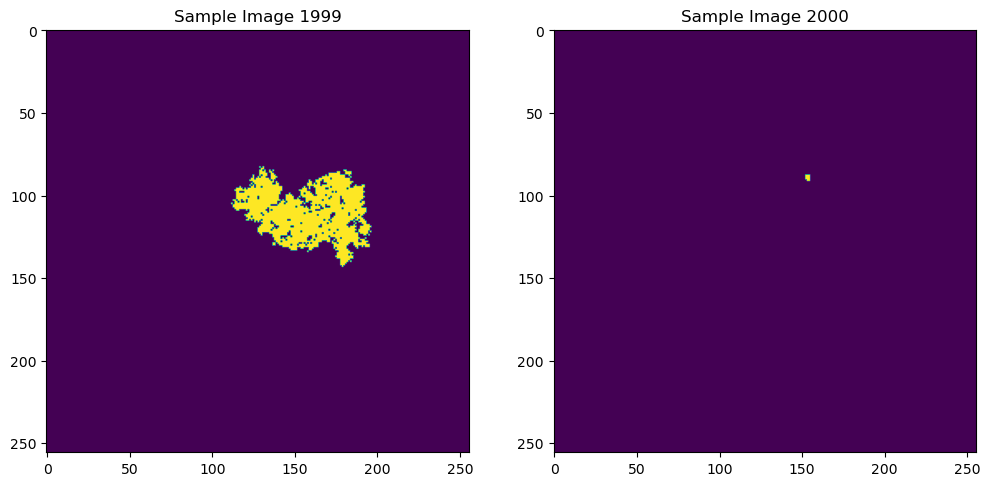

In [6]:
# Select two sample timesteps
sample_image_1 = train[1999]
sample_image_2 = train[2000]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# the first timestep
axs[0].imshow(sample_image_1)
axs[0].set_title('Sample Image 1999')

# the second timestep
axs[1].imshow(sample_image_2)
axs[1].set_title('Sample Image 2000')

# Display images
plt.show()

**We visualise the training data, and find that the majority fire goes from fully developed (covering a large area) to a single point every 100 timesteps. This confirms our choice of 100 timestep makes sense.**

**The delta t of background data is 10 time steps, therefore, we extract 1 image per 10 time steps and feed them into our LSTM for prediction. After testing, MSE score by that mean is smaller than the MSE score from feeding neighbour images into the model. 10 times training of model that way garantees a better prediction.**

In [15]:
def lstm_input(data, n):
    data = data[n*100:(n+1)*100,:,:]

    new_train = []
    for i in range(79):
        selected_train = data[i:21+i:10, :, :]  # Select every 10th time step before time step 100
        new_train.append(selected_train)

    train = np.reshape(new_train, (-1,3,256,256,1))
    return train

In [18]:
x_train = []
for i in range(125):
    x_train.append(lstm_input(train, i))
x_train = np.array(x_train)
x_train = np.reshape(x_train, (-1 ,3 ,256 ,256 ,1))
print(np.shape(x_train))

(9875, 3, 256, 256, 1)


In [25]:
difference = x_train[:, 0, :, :, :] - x_train[:, -1, :, :, :]
mse_per_group = np.mean(np.square(difference), axis=(1, 2, 3))

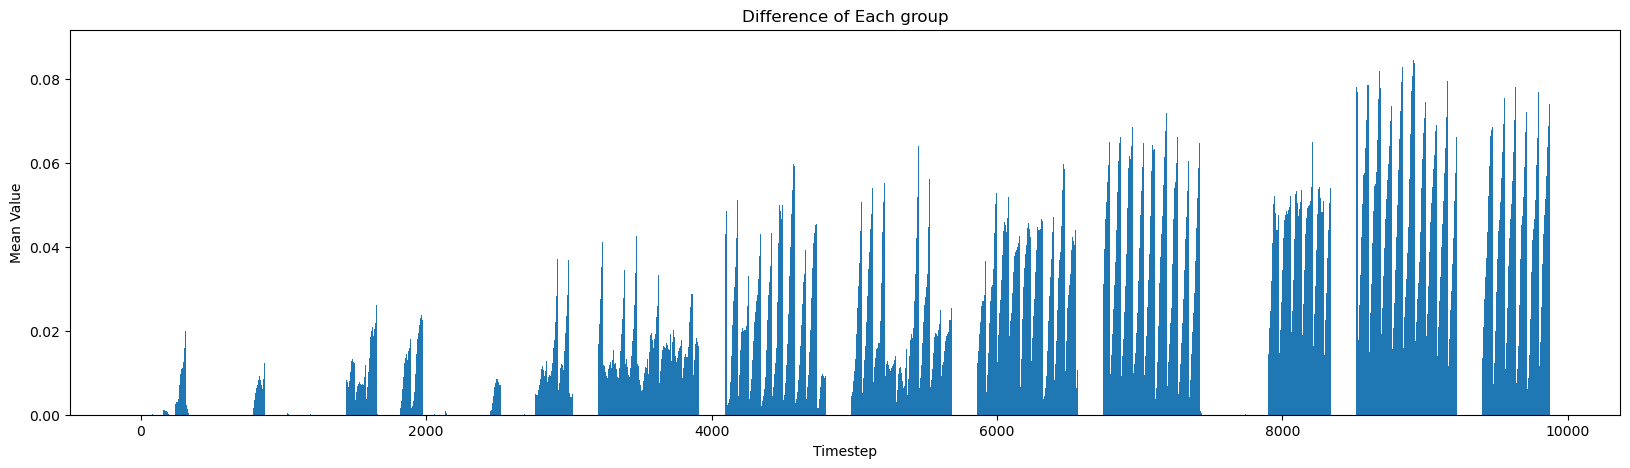

In [21]:
plt.figure(figsize=(20,5))

# Create a histogram
plt.bar(range(len(mse_per_group)), mse_per_group)

plt.title('Difference of Each group')
plt.xlabel('Timestep')
plt.ylabel('Mean Value')

# Display image
plt.show()

In [22]:
indices = mse_per_group > 0

# filter the x_train data
x_train_filtered = x_train[indices]
x_train_filtered.shape

(7650, 3, 256, 256, 1)

**As we can see in the chart of difference, part of it is constant. We tried to remove those part in the early training in case they make our model less precise. There is the training loss and prediction:**

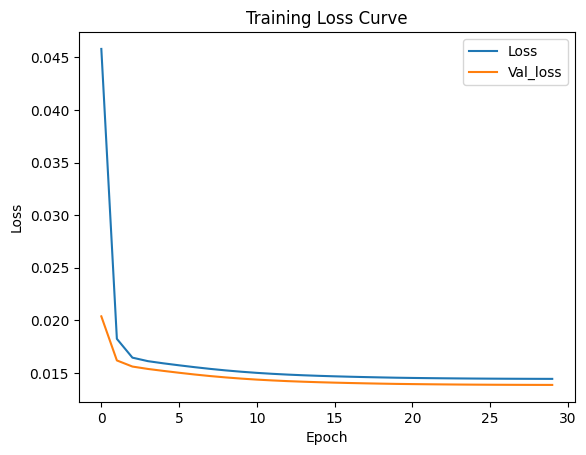

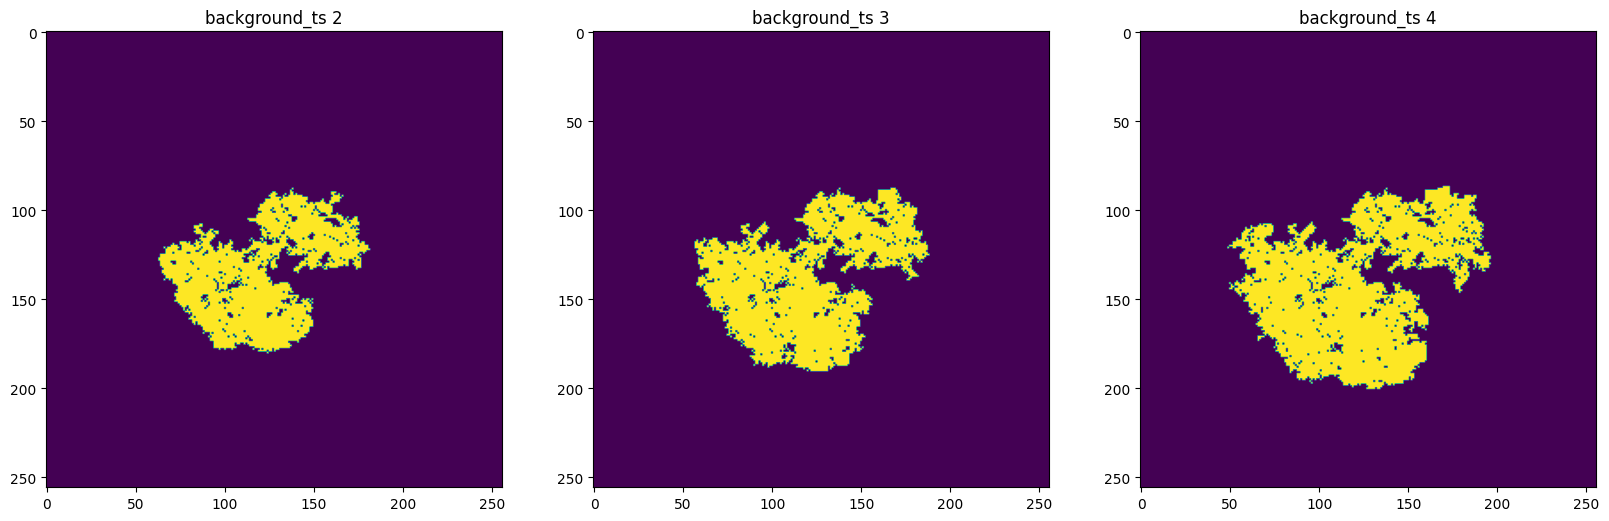

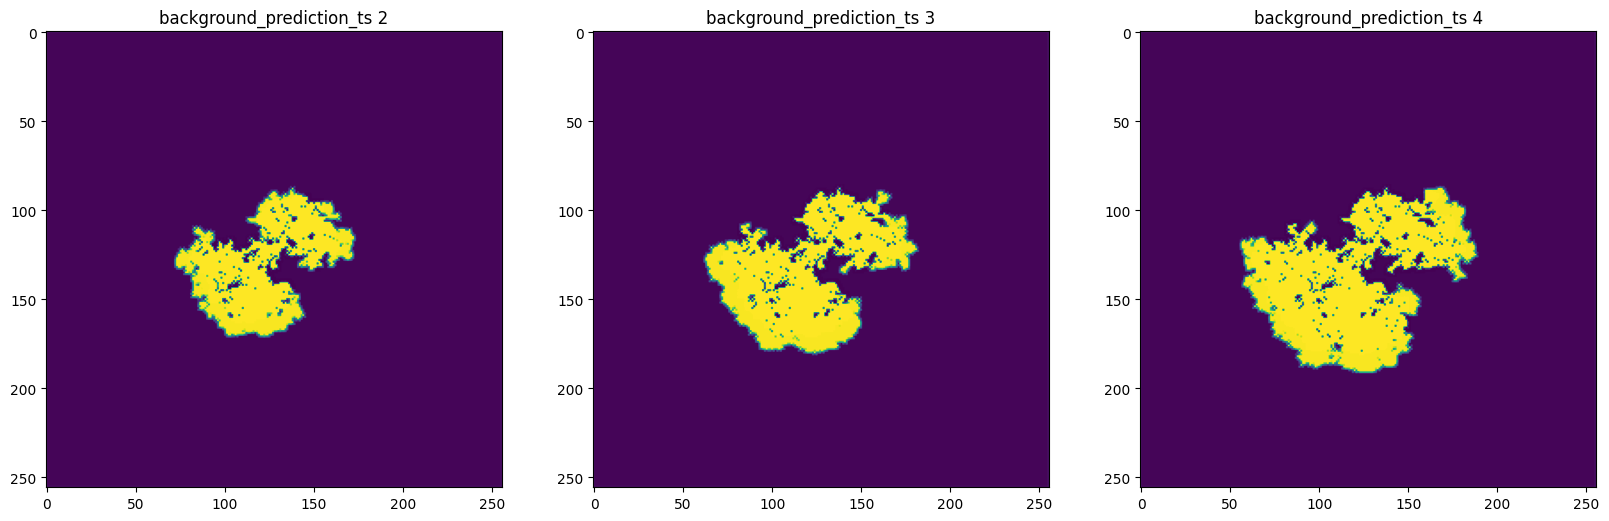

**However, the result came out not satisfying. MSE between background_prediction and satellite_data were not reduced; also, fire on the predicted images didn't expand as expected. We aborted this approach at the end.**

**At mean time, we tried varying our hyperparameters, like batch size, epoch number, activation function. The optimal combination of hyperparameters are batch size = 64, epoch = 30 and activation function = Sigmoid.**

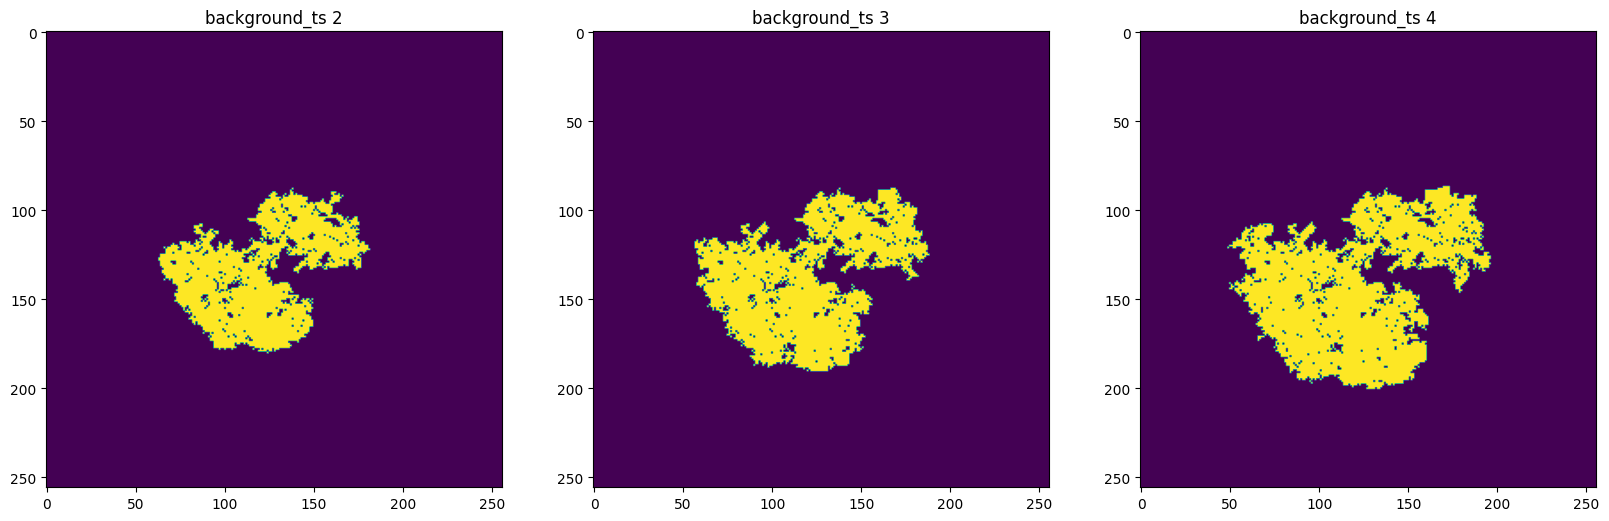

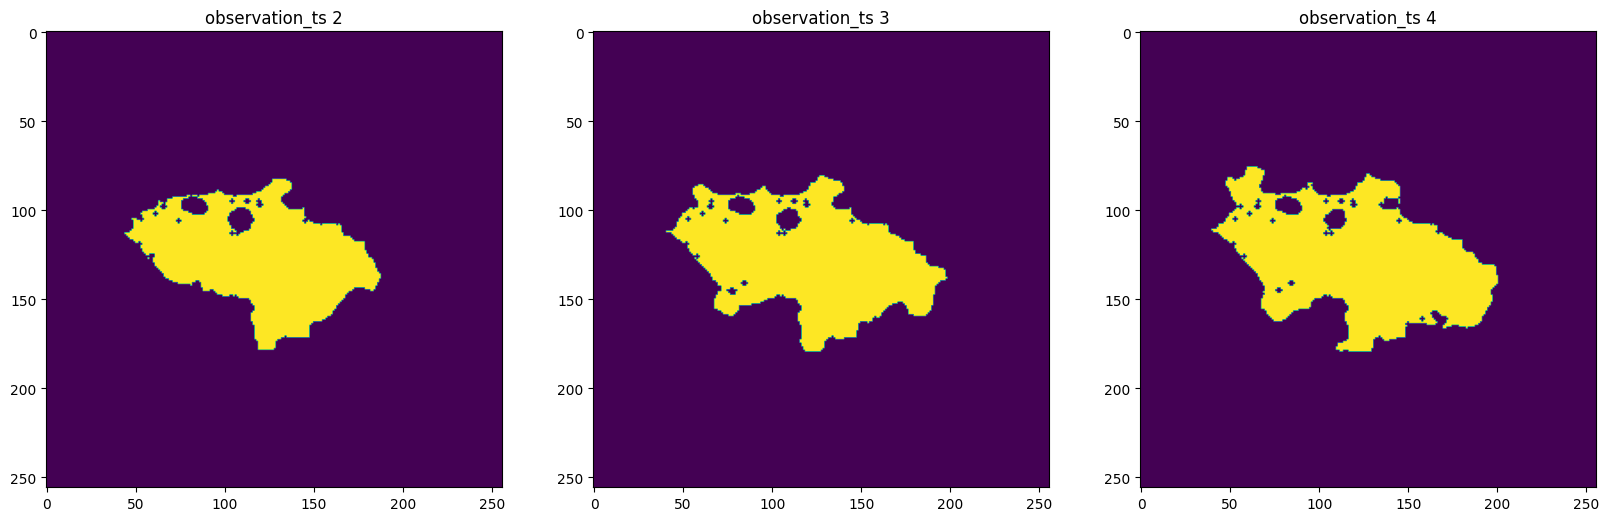

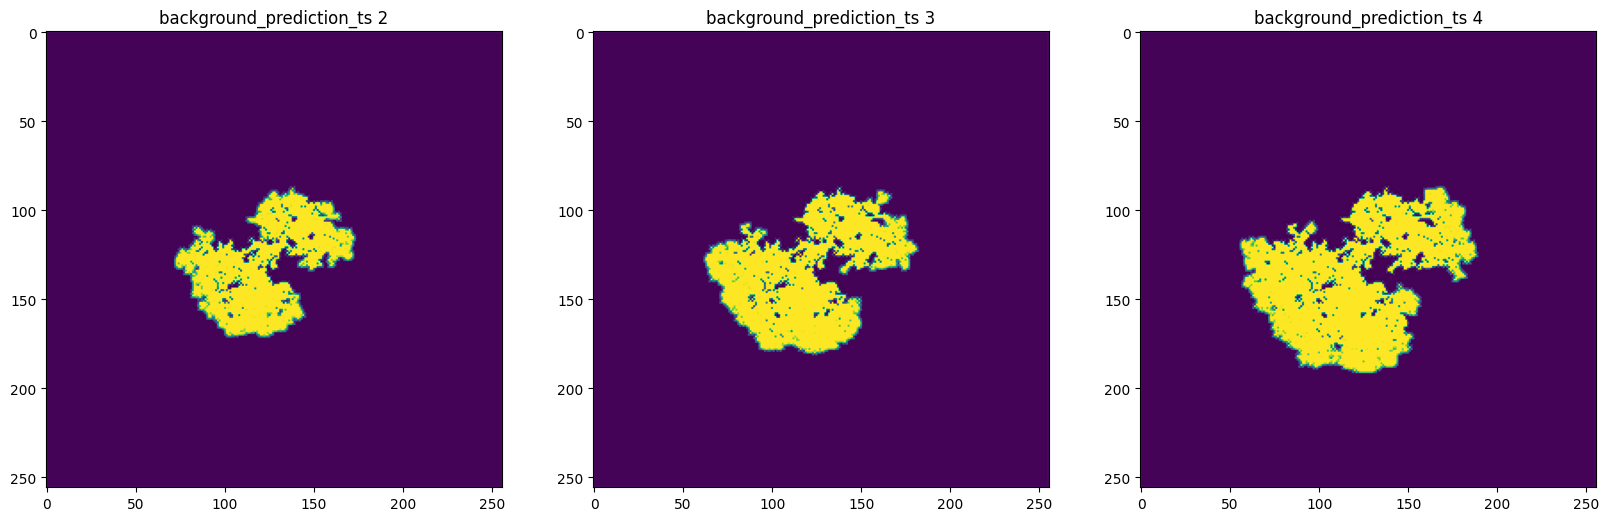

**Obviously, background_prediction didn't totally reach our expectation. It could be the case that the structure of our Convolutional LSTM is not complicated enough. Not that we could build a complicated one without our kernel keeping crashing, it is still a very possible way to improve model performance.**